In [1]:
import pandas as pd
import scipy as sp

from abtools.bayesian import WaldARPUABModel, LognormalARPUABModel

%matplotlib inline

In [2]:
mu = 9
size = 300
delta_true = .015

arppu_a = pd.Series(sp.stats.wald.rvs(loc=mu, size=size, random_state=8228))
arppu_b = pd.Series(sp.stats.wald.rvs(loc=mu*(1+delta_true), size=size, random_state=8228))

print('ARPPU')
print('Mean: %.4f' % arppu_a.mean())
print('Mean: %.4f' % arppu_b.mean())
print('B больше A на %.4f = %d%%' % (arppu_b.mean()- arppu_a.mean(), 
                                    (arppu_b.mean()/arppu_a.mean()-1)*100))

p = .03
size = 10000
delta_true = .05

c_a = pd.Series(sp.stats.bernoulli.rvs(p=p, size=size, random_state=8228))
c_b = pd.Series(sp.stats.bernoulli.rvs(p=p*(1+delta_true), size=size, random_state=8228))

print('Mean: %.4f' % (c_a.mean()))
print('Mean: %.4f' % (c_b.mean()))
print('y2 больше y1 на %.4f = %d%%' % (c_b.mean()- c_a.mean(), (c_b.mean()/c_a.mean()-1)*100))

ARPPU
Mean: 9.9796
Mean: 10.1146
B больше A на 0.1350 = 1%
Mean: 0.0303
Mean: 0.0320
y2 больше y1 на 0.0017 = 5%


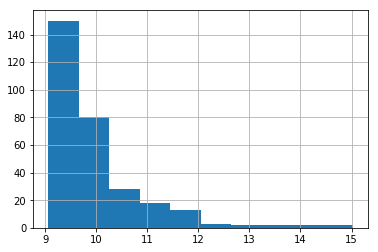

In [3]:
arppu_a.hist()

In [4]:
model = WaldARPUABModel(c_a, c_b, arppu_a, arppu_b)

/usr/local/lib/python3.5/dist-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
/usr/local/lib/python3.5/dist-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [5]:
model.fit()

         Current function value: 3602.075520
         Iterations: 32
         Function evaluations: 126
         Gradient evaluations: 115


100%|██████████| 10000/10000 [00:08<00:00, 1216.69it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efd5857e860>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7efd548cc390>], dtype=object)

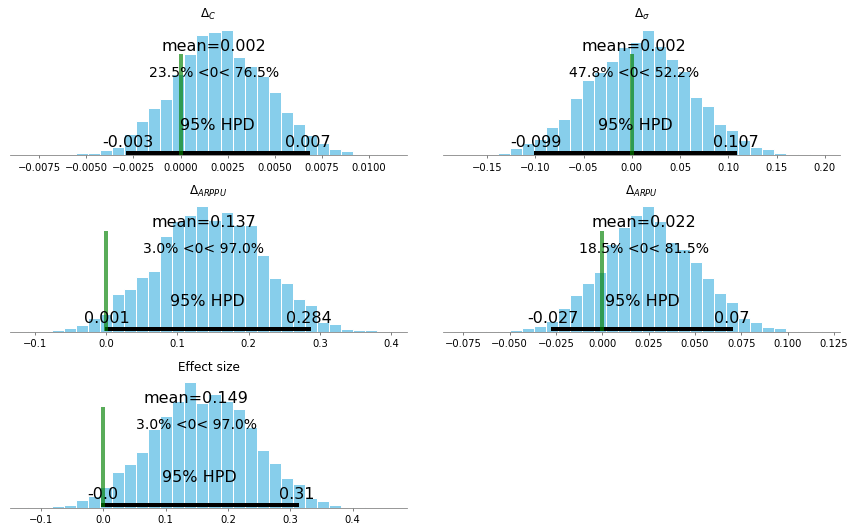

In [6]:
model.plot_deltas()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efd4e8e4e10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7efd4ccf1780>], dtype=object)

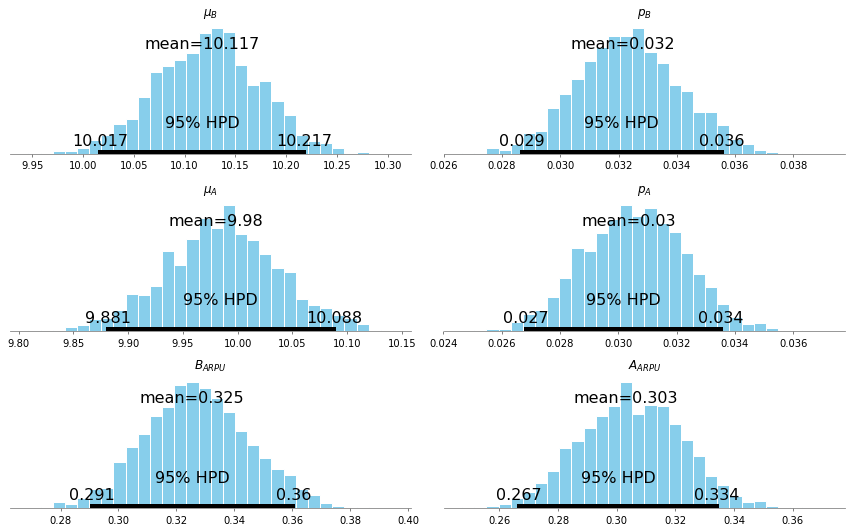

In [7]:
model.plot_params()

In [3]:
model = LognormalARPUABModel(c_a, c_b, arppu_a, arppu_b)

/usr/local/lib/python3.5/dist-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
/usr/local/lib/python3.5/dist-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [4]:
model.fit()

         Current function value: 3576.532580
         Iterations: 71
         Function evaluations: 148
         Gradient evaluations: 137


100%|██████████| 10000/10000 [00:09<00:00, 1089.20it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e29cfbd30>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2e27504828>], dtype=object)

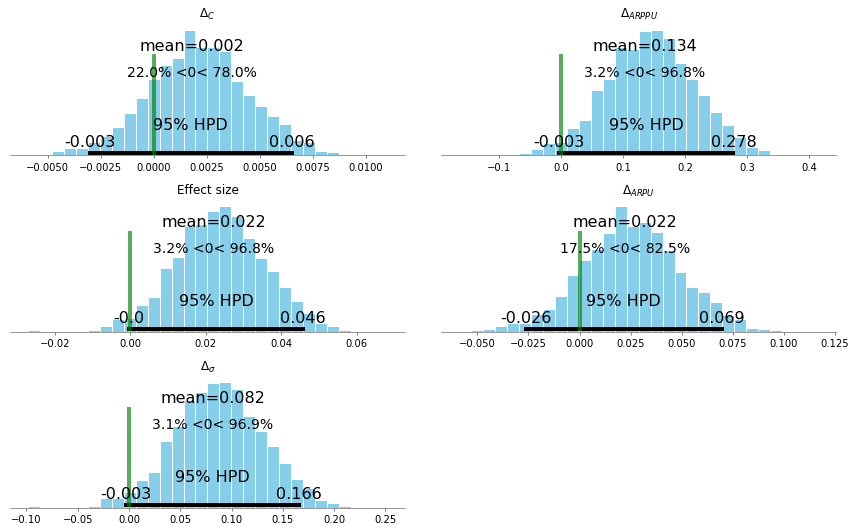

In [5]:
model.plot_deltas()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e256c6f28>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f2e1cf64b38>], dtype=object)

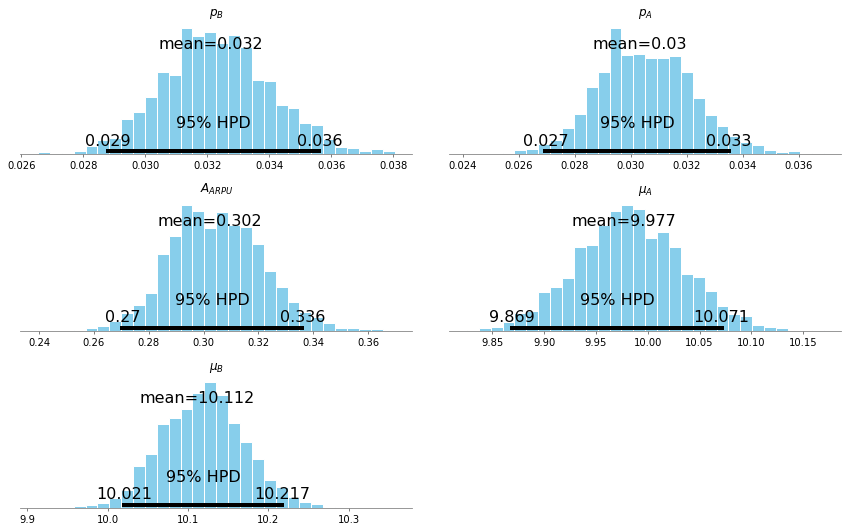

In [6]:
model.plot_params()

In [7]:
model.summary()

,mean,sd,mc_error,hpd_2.5,hpd_97.5
$\alpha_A$,569.351335,246.975411,23.992137,122.266165,981.833822
$\beta_A$,4.441335,1.962061,0.190638,0.629695,7.615439
$\lambda_A$,129.152037,10.525497,0.621737,108.950057,149.909689
$\mu_{ln(A)}$,2.296381,0.005131,0.000120,2.285881,2.306089
$\alpha_B$,0.021759,0.010427,0.000200,0.010009,0.042041
$\beta_B$,496.020026,282.578930,6.113991,10.107999,946.026606
$\lambda_B$,130.684639,10.380059,0.230854,110.618521,150.613969
$\mu_{ln(B)}$,2.309813,0.005000,0.000130,2.300360,2.319672
$\mu_A$,9.977091,0.051304,0.001207,9.869388,10.071320
$\mu_B$,10.111521,0.050632,0.001325,10.020720,10.217010
